In [36]:
import pandas as pd

# 1. Load the datasets
# Replace 'labels.csv' and 'metrics.csv' with your actual filenames
df_labels = pd.read_csv('../data/intermediate/zcommits_icvul.csv')
df_metrics = pd.read_csv('../data/raw/commit_info.csv')

# 2. Merge the dataframes
# We join 'commit_id' from the first file with 'hash' from the second file
df_vuln = pd.merge(
    df_labels, 
    df_metrics, 
    left_on='commit_id', 
    right_on='hash', 
    how='inner'
)

# 3. Calculate Churn
# Churn is defined as the total number of lines modified
df_vuln['churn'] = df_vuln['num_lines_added'] + df_vuln['num_lines_deleted']
df_vuln['Dataset'] = 'Vulnerability'
df_vuln['Type'] = df_vuln['commit_role'].map({'VIC': 'Inducing', 'VFC': 'Fixing'})

# 4. Group by commit_role (VIC vs VFC) and calculate statistics
# We calculate the sum (total churn) and the mean (average churn per commit)
churn_results = df_vuln.groupby('commit_role')['churn'].agg(['sum', 'mean', 'median', 'count'])

# Rename columns for clarity
churn_results.columns = ['Total Churn', 'Average Churn', 'Median Churn', 'Commit Count']

print("Churn Statistics by Commit Role:")
print(churn_results)

Churn Statistics by Commit Role:
             Total Churn  Average Churn  Median Churn  Commit Count
commit_role                                                        
VFC               405067     103.571209          11.0          3911
VIC             50095117    6068.457541         164.0          8255


In [37]:
import pandas as pd

# 1. Load the datasets
# churn.csv contains the churn, commits_dataset_linux.csv contains the labels
df_churn = pd.read_csv('../data/intermediate/churn.csv')
df_labels = pd.read_csv('../data/intermediate/commits_dataset_linux.csv')

# 2. Merge the datasets on 'commit_id'
# We use an inner join to ensure we only analyze commits that exist in both files
df_bug = pd.merge(df_labels, df_churn, on='commit_id', how='inner')
df_bug['Dataset'] = 'Bug'
df_bug['Type'] = df_bug['commit_role'].map({'BIC': 'Inducing', 'BFC': 'Fixing'})

# 3. Group by 'commit_role' (BIC vs BFC) and calculate stats
# We calculate statistics for the 'churn' column
stats = df_bug.groupby('commit_role')['churn'].agg(['sum', 'mean', 'median', 'std', 'count'])

# 4. Clean up the output column names
stats.columns = ['Total Churn', 'Average Churn', 'Median Churn', 'Std Dev', 'Commit Count']

print("Churn Statistics for BIC vs BFC (Linux Dataset):")
print(stats)

# Optional: Calculate stats for 'files_changed' as well
files_stats = df_bug.groupby('commit_role')['files_changed'].mean()
print("\nAverage Files Changed:")
print(files_stats)

Churn Statistics for BIC vs BFC (Linux Dataset):
             Total Churn  Average Churn  Median Churn        Std Dev  \
commit_role                                                            
BFC                 6284      12.321569           5.0      20.273826   
BIC              6932127   14147.197959         110.5  303505.224527   

             Commit Count  
commit_role                
BFC                   510  
BIC                   490  

Average Files Changed:
commit_role
BFC     1.305882
BIC    39.355102
Name: files_changed, dtype: float64


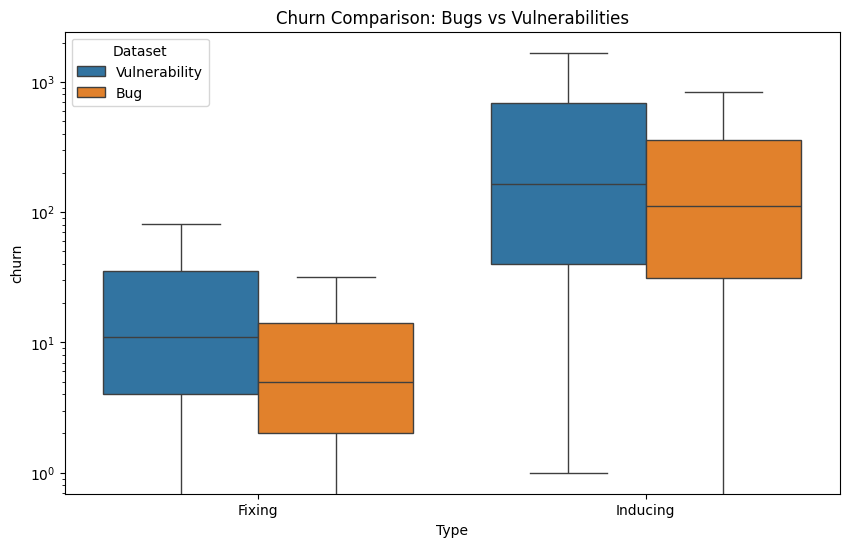

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the two already-processed dataframes
df_plot = pd.concat([df_vuln[['churn', 'Dataset', 'Type']], 
                     df_bug[['churn', 'Dataset', 'Type']]])

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_plot, x='Type', y='churn', hue='Dataset', showfliers=False)

ax.set_yscale("log")
plt.title('Churn Comparison: Bugs vs Vulnerabilities')
plt.show()

In [32]:
# Combine the prepared data
df_all = pd.concat([df_vuln, df_bug])

# Create a summary table
summary_table = df_all.groupby(['Type', 'Dataset'])['churn'].agg([
    'count', 
    'median', 
    'mean', 
    'std'
]).round(2)

# Rename columns for a professional look
summary_table.columns = ['Total Commits', 'Median Churn', 'Average Churn', 'Std Dev']

print("Summary Table: Bug vs. Vulnerability Churn")
display(summary_table)

Summary Table: Bug vs. Vulnerability Churn


Total Commits  Median Churn  Average Churn    Std Dev
Type     Dataset                                                             
Fixing   Bug                      510           5.0          12.32      20.27
         Vulnerability           3911          11.0         103.57    1986.09
Inducing Bug                      490         110.5       14147.20  303505.22
         Vulnerability           8255         164.0        6068.46  138717.33